<a href="https://colab.research.google.com/github/alyilmaz99/surface_crack_cnn_detect/blob/main/surface_crack_cnn_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile

from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing import image
from pathlib import Path
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

##https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

In [ ]:
! pip install -q kaggle

In [ ]:
!pip install -q opendatasets
import opendatasets as od

od.download('https://www.kaggle.com/datasets/arunrk7/surface-crack-detection')



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alyyilmaz
Your Kaggle Key: ··········


100%|██████████| 233M/233M [00:01<00:00, 202MB/s]


In [ ]:
data_folder = '/content/surface-crack-detection/'

infected_folder = os.path.join(data_folder, 'Positive')
not_infected_folder = os.path.join(data_folder, 'Negative')



In [ ]:
import glob
def delete_photos(root, silinecek_adet):
    resimler = glob.glob(os.path.join(root, '*.jpg'))

    # Silinecek adet kadar resmi sil
    for i in range(min(silinecek_adet, len(resimler))):
        resim = resimler[i]
        os.remove(resim)
        print(f"{resim} silindi.")

root = '/content/surface-crack-detection/Positive'
root2 = '/content/surface-crack-detection/Negative'
#root3 = '/content/surface-crack-detection/test/validation'
# Silinecek resim sayısını belirtin
silinecek_adet = 5000

#delete_photos(root, silinecek_adet)
#delete_photos(root2,silinecek_adet)
#delete_photos(root3, silinecek_adet)


Streaming output truncated to the last 5000 lines.
/content/surface-crack-detection/Negative/00793.jpg silindi.
/content/surface-crack-detection/Negative/04469.jpg silindi.
/content/surface-crack-detection/Negative/14991.jpg silindi.
/content/surface-crack-detection/Negative/19443.jpg silindi.
/content/surface-crack-detection/Negative/05158.jpg silindi.
/content/surface-crack-detection/Negative/04900.jpg silindi.
/content/surface-crack-detection/Negative/18952.jpg silindi.
/content/surface-crack-detection/Negative/08804.jpg silindi.
/content/surface-crack-detection/Negative/05060.jpg silindi.
/content/surface-crack-detection/Negative/16402.jpg silindi.
/content/surface-crack-detection/Negative/11677.jpg silindi.
/content/surface-crack-detection/Negative/19113.jpg silindi.
/content/surface-crack-detection/Negative/15730.jpg silindi.
/content/surface-crack-detection/Negative/17968.jpg silindi.
/content/surface-crack-detection/Negative/05840.jpg silindi.
/content/surface-crack-detection/N

In [ ]:
import shutil
import random


source_directory_positive = "/content/surface-crack-detection/Positive"
source_directory_negative = "/content/surface-crack-detection/Negative"

positive_images = os.listdir(source_directory_positive)
negative_images = os.listdir(source_directory_negative)

test_directory = "/content/test/validation"
os.makedirs(test_directory, exist_ok=True)

random_positive_images = random.sample(positive_images, 5000)
for image in random_positive_images:
    source_path = os.path.join(source_directory_positive, image)
    target_path = os.path.join(test_directory, image)
    shutil.move(source_path, target_path)

random_negative_images = random.sample(negative_images, 5000)
for image in random_negative_images:
    source_path = os.path.join(source_directory_negative, image)
    target_path = os.path.join(test_directory, image)
    shutil.move(source_path, target_path)

print("Resimler başarıyla taşındı.")


Resimler başarıyla taşındı.


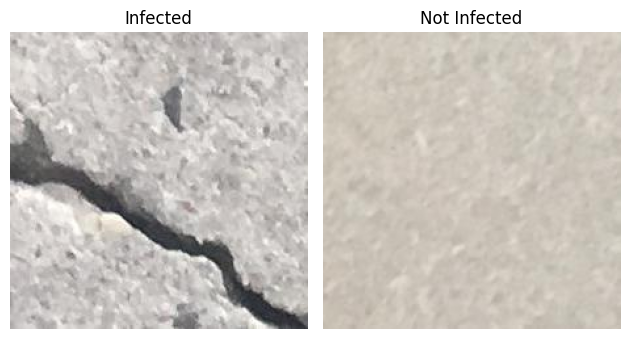

In [ ]:

sample_infected_image = Image.open(os.path.join(infected_folder, os.listdir(infected_folder)[10]))
sample_not_infected_image = Image.open(os.path.join(not_infected_folder, os.listdir(not_infected_folder)[10]))

plt.subplot(1, 2, 1)
plt.imshow(sample_infected_image)
plt.title("Infected")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_not_infected_image)
plt.title("Not Infected")
plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
infected_images = [os.path.join(infected_folder, img) for img in os.listdir(infected_folder)]
not_infected_images = [os.path.join(not_infected_folder, img) for img in os.listdir(not_infected_folder)]
labels_infected = [1] * len(infected_images)
labels_not_infected = [0] * len(not_infected_images)



In [ ]:
all_images = infected_images + not_infected_images
all_labels = labels_infected + labels_not_infected

In [ ]:

train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, shuffle=True
)



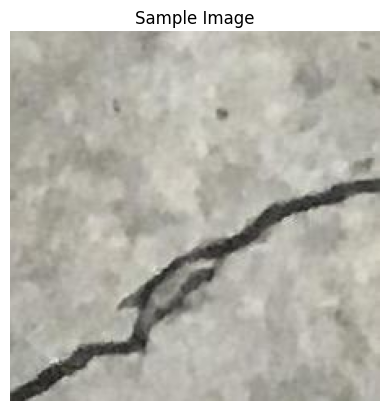

In [ ]:
sample_image = Image.open(train_images[0])
plt.imshow(sample_image)
plt.title("Sample Image")
plt.axis('off')
plt.show()

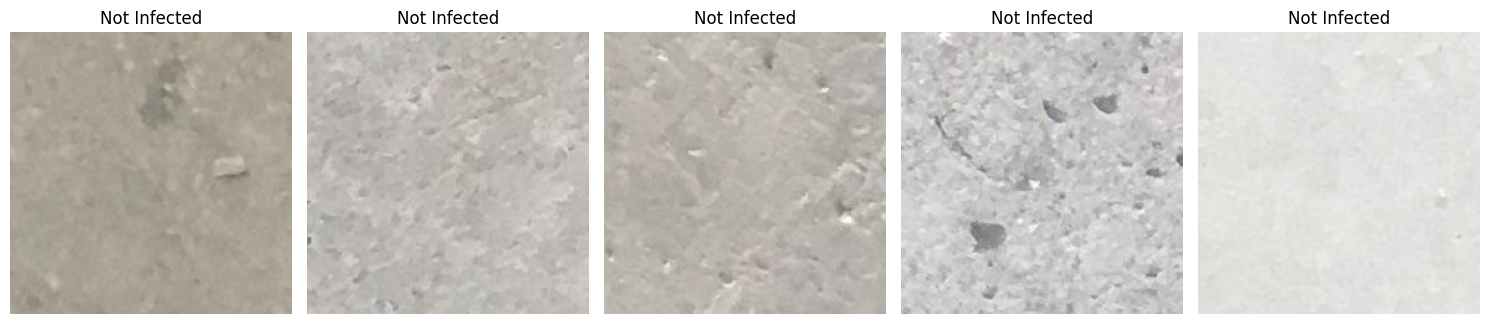

In [ ]:
not_infected_indices = [i for i, label in enumerate(train_labels) if label == 0]

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(Image.open(train_images[not_infected_indices[i]]))
    plt.title("Not Infected")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
'''
def create_dataset(image_paths, labels, image_size=(224, 224), batch_size=254):
    while True:
        images = []
        for img_path, label in zip(image_paths, labels):
            img = Image.open(img_path).resize(image_size)
            img = np.array(img) / 255.0
            images.append(img)
            if len(images) == batch_size:
                yield np.array(images), np.array(labels[:len(images)])
                images = []

        if not images:
            break
'''

In [73]:
'''
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2)
])
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

'''
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),

    Flatten(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax')
])



In [74]:

from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [75]:
#train_generator = create_dataset(train_images, train_labels, batch_size=128)
#test_generator = create_dataset(test_images, test_labels, batch_size=128)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=50)
from keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)

train_datagen = ImageDataGenerator(
   rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)
test_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_generator = train_datagen.flow_from_directory(
    "/content/surface-crack-detection",
    target_size=image_size,
    batch_size=128,
    class_mode='binary',
    subset='training'
)
test_generator = train_datagen.flow_from_directory(
    "/content/test",
    target_size=image_size,
    batch_size=128,
    class_mode='binary',
)




Found 20000 images belonging to 2 classes.
Found 9076 images belonging to 1 classes.


In [ ]:
tf.data.experimental.enable_debug_mode()
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]
)


Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 1.0585 - accuracy: 0.9222

In [ ]:
model.save('/content/my_model.h5')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test, label = test_generator.__next__()
predicts=model.predict(test)

predicts = np.argmax(predicts, axis=1)
test_labels = np.argmax(label, axis=1)

from sklearn import metrics
print ("Acc = ", metrics.accuracy_score(test_labels, predicts))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predicts)
import seaborn as sns
sns.heatmap(cm, annot=True)


In [ ]:
from keras.models import load_model

loaded_model = load_model('/content/my_model.h5')



In [ ]:
test_image = Image.open('/content/surface-crack-detection/Negative/00047.jpg')
test_image = test_image.resize((224, 224))
test_image = np.array(test_image) / 255.0


predictions = loaded_model(np.expand_dims(test_image, axis=0))

predicted_class = np.argmax(predictions, axis=1)

if predicted_class == 0:
    predict = "Negative"

else:
   predict = "Positive"

plt.imshow(test_image)
plt.title( predict)
plt.axis('off')
plt.show()